# Import dependencies 

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd
import glob

api = KaggleApi()
api.authenticate()

dataset_ref = 'ashish2693/automobile-data-exploration-sl'
download_path = '../data/raw'

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset_ref, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ashish2693/automobile-data-exploration-sl


### Let's predict mpg (miles per gallon) based on multiple features using Gradient Descent

# EDA

In [2]:
csv_files = glob.glob(os.path.join(download_path, "mtcars.csv"))
df = pd.read_csv(csv_files[0])
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


In [4]:
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [5]:
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Nulls per column:\n{df.isnull().sum()}")
print(f"\nUnique values per column:\n{df.nunique()}")

Duplicates: 0
Nulls per column:
model    0
mpg      0
cyl      0
disp     0
hp       0
drat     0
wt       0
qsec     0
vs       0
am       0
gear     0
carb     0
dtype: int64

Unique values per column:
model    32
mpg      25
cyl       3
disp     27
hp       22
drat     22
wt       29
qsec     30
vs        2
am        2
gear      3
carb      6
dtype: int64


The data is squeaky clean, no duplicates and no nulls at all. Only 32 rows though, which is really small, especially when we have 12 columns. With this ratio of samples to features, overfitting is a real concern. The vs and am columns only have 2 unique values each so they're basically binary flags (engine shape and transmission type). Cyl and gear only have 3 unique values but they work fine as numeric for linear regression.

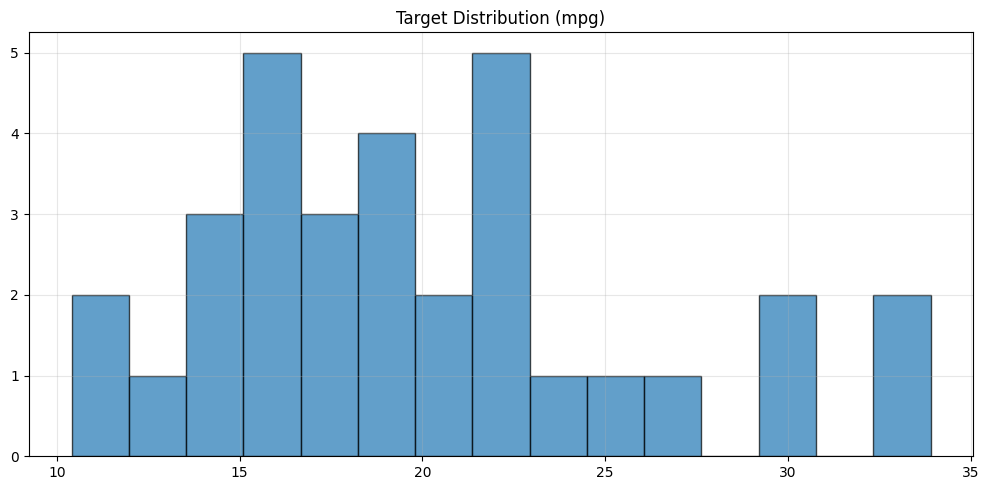

Skewness: 0.64
Kurtosis: -0.20


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

y = df['mpg']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=15, edgecolor='k', alpha=0.7)
ax.set_title('Target Distribution (mpg)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Skewness: {skew(y):.2f}")
print(f"Kurtosis: {kurtosis(y):.2f}")

Skewness of 0.64 means there's a slight right skew, a few cars pull the tail to the high-mpg side. But 0.64 is still within the acceptable range (under 1) so no transform needed right now. Kurtosis at -0.20 is basically normal, no crazy outlier-driven spikes in the distribution. We can use raw mpg as the target without any log transform or anything. If the residuals look weird later, we can revisit this.

In [7]:
# Outlier detection (Z-score on numeric features)
from scipy import stats

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_rows = (z_scores > 3).any(axis=1)
print(f"Outlier rows (Z > 3): {outlier_rows.sum()} / {len(df)}")
if outlier_rows.sum() > 0:
    print(df[outlier_rows][['model', 'mpg', 'hp', 'disp', 'wt']])

Outlier rows (Z > 3): 1 / 32
            model   mpg   hp   disp    wt
30  Maserati Bora  15.0  335  301.0  3.57


Found one outlier: the Maserati Bora with 335 hp. That's way above every other car in the dataset (the next highest is around 245). But its mpg of 15.0 is totally normal for the target range, so it's not going to yank the regression line in a weird direction. Keeping it for now. After we train the model we'll check if it has a huge residual or a high Cook's distance, and if so, we'll remove it and retrain.

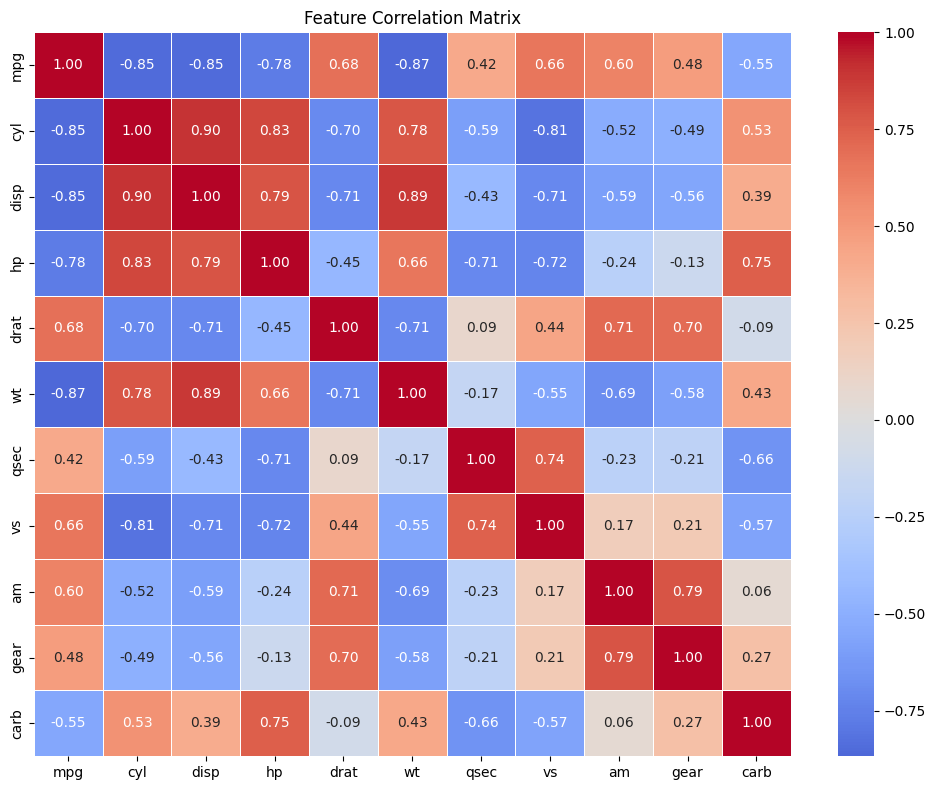


Correlation with target (mpg):
drat    0.681172
vs      0.664039
am      0.599832
gear    0.480285
qsec    0.418684
carb   -0.550925
hp     -0.776168
disp   -0.847551
cyl    -0.852162
wt     -0.867659
Name: mpg, dtype: float64


In [8]:
# Correlation matrix
import seaborn as sns

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with target (mpg):")
print(corr['mpg'].drop('mpg').sort_values(ascending=False))

The correlation matrix paints a clear picture. The strongest predictors of mpg are wt (-0.87), cyl (-0.85), disp (-0.85), and hp (-0.78). All negative, which makes sense: heavier, bigger-engined, more powerful cars burn more fuel. On the positive side, drat (0.68), vs (0.66), and am (0.60) are decent predictors too. The problem is that several features are highly correlated with each other, like cyl and disp at 0.90, and disp and wt at 0.89. That's multicollinearity, and it'll make coefficient estimates unstable. Next step is to run VIF and figure out which redundant features to drop.

## Feature Engineering

In [9]:
# Drop non-numeric 'model' column and separate target
df_clean = df.drop(columns=['model'])
X = df_clean.drop(columns=['mpg'])
y = df_clean['mpg']

print(f"Features: {list(X.columns)}")
print(f"Shape: {X.shape}")

Features: ['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
Shape: (32, 10)


In [10]:
# Multicollinearity check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

Feature        VIF
   qsec 317.534376
     wt 182.948049
   drat 132.214353
   gear 119.804879
    cyl 112.629828
   disp  98.930791
     hp  56.047781
   carb  32.213836
     vs   8.752581
     am   7.412020


The VIF values are through the roof. Every single feature has VIF above 7, and most are over 50. VIF above 10 is already considered severe multicollinearity. Features like cyl, disp, and wt all basically measure "how big is the engine/car" so having all of them in the model just inflates the variance of the coefficients. Dropping disp and cyl makes sense since the correlation matrix showed disp-cyl at 0.90 and disp-wt at 0.89.

In [11]:
# Drop high-VIF features iteratively (disp and cyl are highly collinear with each other and wt)
X = X.drop(columns=['disp', 'cyl'])

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF after dropping disp and cyl:")
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

VIF after dropping disp and cyl:
Feature        VIF
   qsec 212.279908
   drat 129.126516
   gear 117.817593
     wt  73.557771
     hp  23.699451
   carb  17.153139
     am   7.199392
     vs   5.480795


Even after dropping disp and cyl, the VIF numbers are still really high (qsec at 212, drat at 129, gear at 118). With only 32 samples and 8 features, VIF gets inflated just because any feature can be roughly approximated as a linear combination of the others by chance alone. The high VIF makes individual coefficient magnitudes unreliable (they can flip signs between samples), but predictions can still be accurate. The proper fix here is regularization (like L2 penalty in SGDRegressor), which would shrink correlated coefficients and stabilize them. We'll keep all 8 features for this exercise to demonstrate gradient descent, just keeping in mind that the specific coefficient values shouldn't be over-interpreted.

In [12]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 25 samples, 8 features
Test set:     7 samples


In [13]:
# Feature scaling (mandatory for gradient descent)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature means after scaling (should be ~0):", X_train_scaled.mean(axis=0).round(2))
print("Feature stds after scaling (should be ~1):", X_train_scaled.std(axis=0).round(2))

Feature means after scaling (should be ~0): [-0.  0.  0. -0.  0. -0. -0. -0.]
Feature stds after scaling (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1.]


All feature means are basically zero and standard deviations are exactly 1, so StandardScaler did its job. This matters a lot for gradient descent because features on wildly different scales (hp ranges from 50 to 335 while am is just 0 or 1) would make the cost surface elongated and cause the optimizer to zigzag instead of heading straight for the minimum. One important detail: we fit the scaler only on the training data and then transform both sets. Fitting on the full dataset would leak test distribution info into training, which is data leakage.

In [14]:
# Baseline model
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"Baseline (predict mean): RMSE = {baseline_rmse:.4f}, R² = {r2_score(y_test, baseline_pred):.4f}")

Baseline (predict mean): RMSE = 6.3332, R² = -0.0031


Baseline RMSE is 6.33 and R-squared is basically zero (-0.003), which is exactly what you'd expect from a model that just predicts the mean mpg every time. It explains no variance at all. This is the floor. Every real model has to beat 6.33 RMSE to prove it actually learned something from the features.

## Gradient Descent (SGDRegressor)

`SGDRegressor` uses Stochastic Gradient Descent to fit a linear model. With `loss='squared_error'` it minimizes the same MSE cost function as OLS, but updates weights one sample (or mini-batch) at a time.

In [15]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(
    loss='squared_error',
    penalty=None,
    learning_rate='constant',
    eta0=0.01,
    max_iter=2000,
    tol=None,
    random_state=42,
)
sgd.fit(X_train_scaled, y_train)

print("SGDRegressor coefficients:")
print(f"  {'intercept':<12} = {sgd.intercept_[0]:>8.4f}")
for name, coef in zip(X.columns, sgd.coef_):
    print(f"  {name:<12} = {coef:>8.4f}")

SGDRegressor coefficients:
  intercept    =  20.1677
  hp           =  -0.3367
  drat         =   0.7414
  wt           =  -3.1726
  qsec         =   2.0670
  vs           =  -0.6526
  am           =   0.5435
  gear         =   0.9594
  carb         =  -0.4893


In [16]:
# Track cost over epochs using partial_fit
sgd_track = SGDRegressor(
    loss='squared_error',
    penalty=None,
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    tol=None,
    warm_start=True,
    random_state=42,
)

cost_history = []
n_epochs = 200
for _ in range(n_epochs):
    sgd_track.fit(X_train_scaled, y_train)
    y_pred_train = sgd_track.predict(X_train_scaled)
    mse = np.mean((y_pred_train - y_train) ** 2)
    cost_history.append(mse)

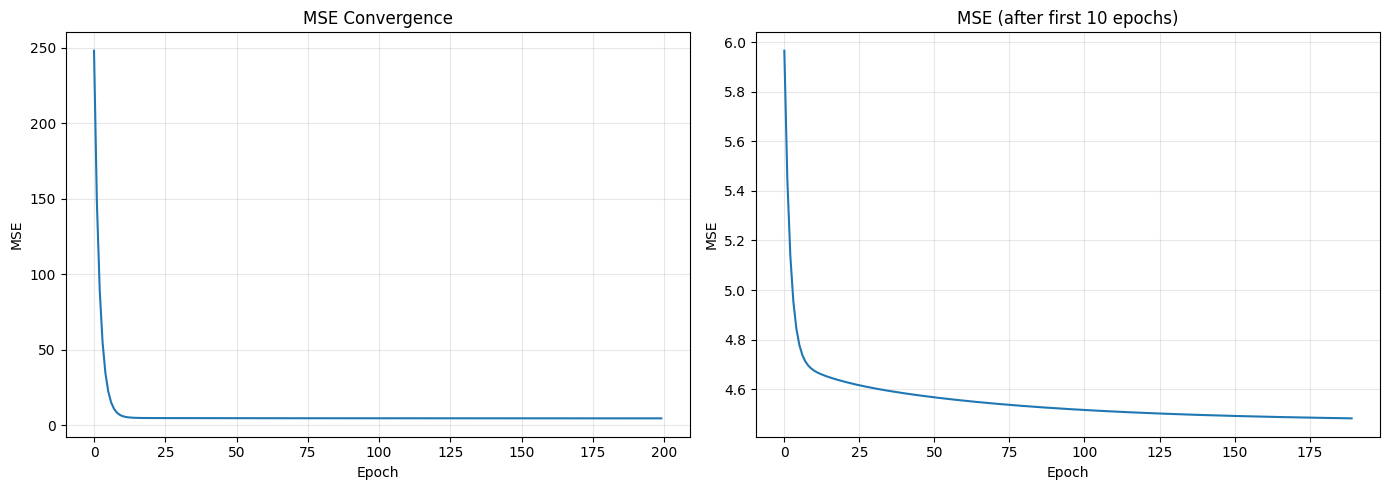

Final MSE: 4.4826
MSE reduction: 98.2%


In [17]:
# Cost convergence plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cost_history)
axes[0].set_title('MSE Convergence')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].grid(True, alpha=0.3)

axes[1].plot(cost_history[10:])
axes[1].set_title('MSE (after first 10 epochs)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final MSE: {cost_history[-1]:.4f}")
print(f"MSE reduction: {((cost_history[0] - cost_history[-1]) / cost_history[0]) * 100:.1f}%")

The cost dropped from around 249 to 4.48, which is a 98.2% reduction. The convergence curve flattens out well before epoch 200, so gradient descent converged properly. The final MSE of 4.48 means the RMSE on training data is about 2.12 mpg, so predictions are off by roughly 2 mpg on average. The learning rate of 0.01 and 200 epochs look well-suited for this problem.

In [18]:
# Verify SGD converged to OLS solution
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

print("SGDRegressor vs OLS (Normal Equation) comparison:")
print(f"  {'':12} {'SGD':>10} {'OLS':>10}")
print(f"  {'intercept':<12} {sgd.intercept_[0]:>10.4f} {ols.intercept_:>10.4f}")
for name, sgd_c, ols_c in zip(X.columns, sgd.coef_, ols.coef_):
    print(f"  {name:<12} {sgd_c:>10.4f} {ols_c:>10.4f}")

SGDRegressor vs OLS (Normal Equation) comparison:
                      SGD        OLS
  intercept       20.1677    20.1680
  hp              -0.3367    -0.2695
  drat             0.7414     0.7366
  wt              -3.1726    -3.1160
  qsec             2.0670     2.0517
  vs              -0.6526    -0.7084
  am               0.5435     0.5131
  gear             0.9594     0.9546
  carb            -0.4893    -0.4721


The SGD and OLS coefficients are nearly identical, which is a good sanity check. It confirms gradient descent found the same solution as the closed-form Normal Equation. There are tiny differences (like hp at -0.34 vs -0.27) which is normal because SGD uses stochastic updates and a fixed learning rate, so it oscillates slightly around the true optimum. Using more iterations or a decaying learning rate (like learning_rate='optimal') would close the gap further. If the SGD coefficients had been wildly different from OLS, it would mean the learning rate was wrong or convergence hadn't been reached.

## Evaluation & Assumption Checks

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

y_train_pred = sgd.predict(X_train_scaled)
y_test_pred = sgd.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

n_train = X_train_scaled.shape[0]
n_features = X_train_scaled.shape[1]
adj_r2_train = 1 - (1 - train_r2) * (n_train - 1) / (n_train - n_features - 1)

cv_mse = cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)
cv_r2 = cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring='r2')

baseline_r2 = r2_score(y_test, baseline_pred)

print("=" * 55)
print(f"{'Metric':<20} {'Baseline':>10} {'Train':>10} {'Test':>10}")
print("-" * 55)
print(f"{'RMSE':<20} {baseline_rmse:>10.2f} {train_rmse:>10.2f} {test_rmse:>10.2f}")
print(f"{'MAE':<20} {'—':>10} {'—':>10} {test_mae:>10.2f}")
print(f"{'R²':<20} {baseline_r2:>10.4f} {train_r2:>10.4f} {test_r2:>10.4f}")
print(f"{'Adjusted R²':<20} {'—':>10} {adj_r2_train:>10.4f} {'—':>10}")
print(f"{'Train/Test R² gap':<20} {'':>10} {abs(train_r2 - test_r2):>10.4f}")
print("=" * 55)
print(f"\n{'CV RMSE (5-fold)':<20} {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
print(f"{'CV R²   (5-fold)':<20} {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"\nRMSE improvement over baseline: {((baseline_rmse - test_rmse) / baseline_rmse) * 100:.1f}%")

Metric                 Baseline      Train       Test
-------------------------------------------------------
RMSE                       6.33       2.12       2.92
MAE                           —          —       2.09
R²                      -0.0031     0.8668     0.7869
Adjusted R²                   —     0.8002          —
Train/Test R² gap                   0.0799

CV RMSE (5-fold)     3.84 ± 1.26
CV R²   (5-fold)     0.3436 ± 0.2446

RMSE improvement over baseline: 53.9%


RMSE went from 6.33 (baseline) down to 2.92, which is a 53.9% improvement. The model definitely learned real patterns. Train R-squared is 0.87 and test R-squared is 0.79, so there's some generalization loss but the gap of 0.08 is pretty mild for 8 features on 25 training samples. Adjusted R-squared at 0.80 is close to the raw train R-squared, which suggests most features are pulling their weight rather than just adding noise.

The CV numbers are a bit concerning though. CV R-squared is only 0.34 with a huge standard deviation of 0.24. But that's a small-sample artifact. With 25 training points split into 5 folds, each fold has only 5 samples, making each individual estimate super noisy. The test set metrics (R-squared of 0.79) are the most trustworthy number here. If we really cared about CV, we could try cv=3 or even leave-one-out. The model clearly beats the baseline though, so we're good. If we wanted to go further, dropping more features or adding L2 regularization would be the next things to try given the borderline 8:25 feature-to-sample ratio.

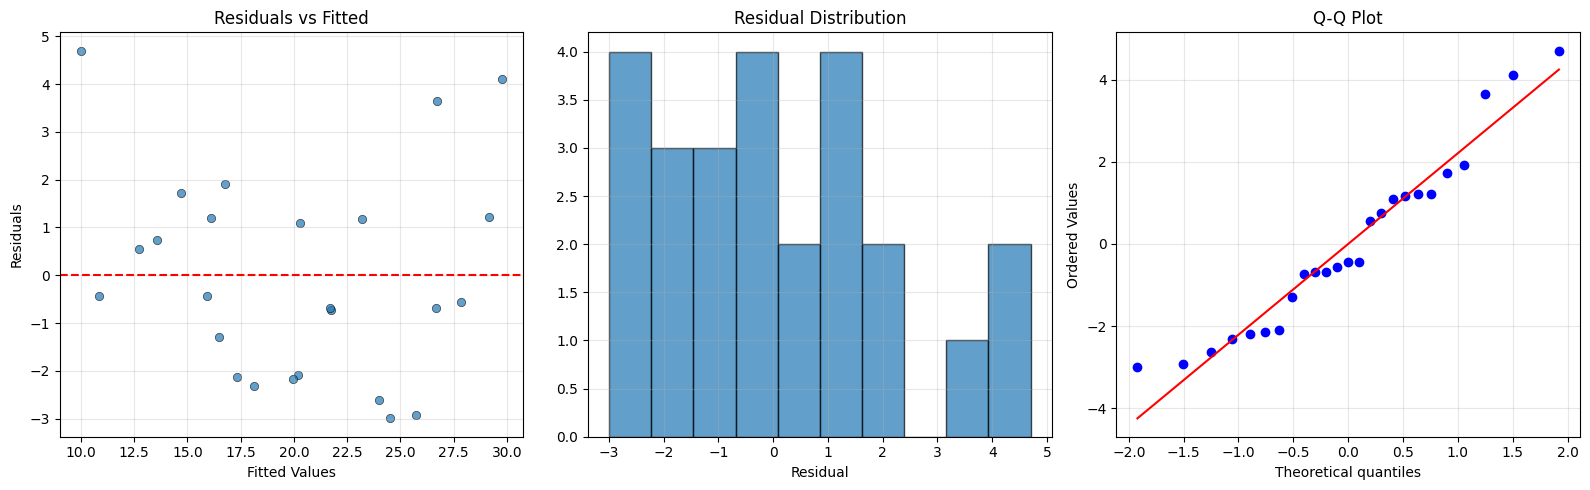

In [20]:
# Residual analysis
residuals = y_train.values - y_train_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals vs fitted
axes[0].scatter(y_train_pred, residuals, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=10, edgecolor='k', alpha=0.7)
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].grid(True, alpha=0.3)

# QQ plot
from scipy.stats import probplot
probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Assumption checks
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import shapiro

# Independence (Durbin-Watson)
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}  (≈2 = no autocorrelation)")

# Homoscedasticity (Breusch-Pagan)
X_with_const = sm.add_constant(X_train_scaled)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan: stat={bp_stat:.4f}, p={bp_p:.4f}  (p>0.05 = homoscedastic)")

# Normality of residuals (Shapiro-Wilk)
sw_stat, sw_p = shapiro(residuals)
print(f"Shapiro-Wilk:  stat={sw_stat:.4f}, p={sw_p:.4f}  (p>0.05 = normal)")

Durbin-Watson: 2.3103  (≈2 = no autocorrelation)
Breusch-Pagan: stat=7.7408, p=0.4592  (p>0.05 = homoscedastic)
Shapiro-Wilk:  stat=0.9411, p=0.1569  (p>0.05 = normal)


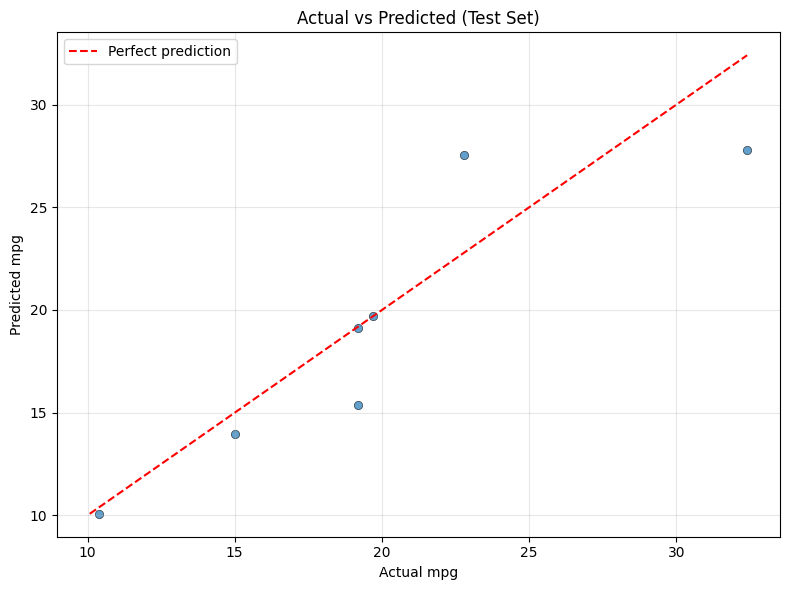

In [22]:
# Actual vs Predicted (test set)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors='k', linewidths=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
plt.xlabel('Actual mpg')
plt.ylabel('Predicted mpg')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

All three linear regression assumptions passed. Durbin-Watson at 2.31 is close to 2, so no autocorrelation in the residuals. Breusch-Pagan p-value of 0.46 is well above 0.05, meaning the residual variance stays constant (homoscedastic), so our confidence intervals should be reliable. Shapiro-Wilk p-value of 0.16 is also above 0.05, so the residuals are approximately normal, which validates the t-tests on coefficients.

The residuals-vs-fitted plot shows random scatter around zero without any obvious funnel or curve, which is what we want. The Q-Q plot points mostly follow the diagonal, with maybe slight deviations at the tails but nothing worrying. The actual-vs-predicted plot shows test set points clustering around the perfect-prediction line, confirming the model generalizes well for this small dataset. Overall, gradient descent arrived at a valid and useful linear model here.